## 쓰레기 이미지 데이터의 BBox Crop하여 클래스 번호의 폴더 위치에 저장

In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import numpy as np
import cv2
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset

# faster rcnn model이 포함된 library
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers

import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger

from typing import Tuple, List, Dict, Optional
from collections import OrderedDict

import random

In [2]:
import os
import cv2
import numpy as np
import torch
from pycocotools.coco import COCO
from torch.utils.data import Dataset
import random

class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
      train: True일 경우 훈련 데이터, False일 경우 검증 데이터
    '''

    def __init__(self, annotation, data_dir, transforms=None, train=True, split_ratio=1, crop_save_dir=None):
        super().__init__()
        self.data_dir = data_dir
        self.coco = COCO(annotation)
        
        # 이미지 IDs 가져오기
        self.img_ids = self.coco.getImgIds()

        # 데이터 분할
        random.shuffle(self.img_ids)  # 무작위로 섞기
        split_idx = int(len(self.img_ids) * split_ratio)
        if train:
            self.img_ids = self.img_ids[:split_idx]  # 훈련 데이터
        else:
            self.img_ids = self.img_ids[split_idx:]  # 검증 데이터

        self.transforms = transforms
        self.crop_save_dir = crop_save_dir  # Crop 이미지를 저장할 경로
        
        if self.crop_save_dir and not os.path.exists(self.crop_save_dir):
            os.makedirs(self.crop_save_dir)  # 경로가 없을 경우 생성

    def __getitem__(self, index: int):
        image_id = self.img_ids[index]  # 분할된 이미지 ID 사용
        image_info = self.coco.loadImgs(image_id)[0]
        
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        if image is None:
            raise ValueError(f"Failed to load image {image_info['file_name']}")
        
        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])

        # boxes (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  # x_max = x_min + width
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  # y_max = y_min + height
        
        # class_id를 1~10으로 수정 
        labels = np.array([x['category_id'] for x in anns]) 
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)
                                  
        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([image_id]),
            'area': areas,
            'iscrowd': is_crowds
        }

        # 이미지에서 BBox를 사용해 crop하여 저장
        if self.crop_save_dir:
            self.save_cropped_images(image, boxes, labels, image_id)

        return image, target, image_id
    
    def __len__(self) -> int:
        return len(self.img_ids)  # 나눠진 데이터의 길이 반환
    
    def save_cropped_images(self, image, boxes, labels, image_id):
        for i, box in enumerate(boxes):
            # Crop the image based on the bounding box
            x_min, y_min, x_max, y_max = box.astype(int)
            cropped_image = image[y_min:y_max, x_min:x_max]

            # Save the cropped image according to its class
            class_label = labels[i].item()  # Convert tensor to integer
            class_folder = os.path.join(self.crop_save_dir, str(class_label))
            os.makedirs(class_folder, exist_ok=True)

            # Create a unique filename for each cropped image
            filename = f'image_{image_id}_{i}.jpg'
            cv2.imwrite(os.path.join(class_folder, filename), cropped_image)


In [3]:
annotation = '/data/ephemeral/dataset/train.json' # annotation 경로
data_dir = '/data/ephemeral/dataset' # data_dir 경로
crop_save_dir = '/data/ephemeral/crop_image'

dataset = CustomDataset(annotation=annotation, data_dir=data_dir, train=True, crop_save_dir=crop_save_dir)

for item in dataset:
    pass

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


## 합성 데이터를 만드는 로직

In [5]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def load_random_images_from_classes(data_dir, max_classes=5, max_images_per_class=5, target_size=(1024, 1024)):
    class_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    
    # 최대 5개의 클래스를 랜덤으로 선택
    num_classes = random.randint(1, max_classes)  # 최소 1개, 최대 5개
    selected_classes = random.sample(class_folders, num_classes)
    
    selected_images = []
    for class_name in selected_classes:
        class_folder = os.path.join(data_dir, class_name)
        images = [img for img in os.listdir(class_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
        
        # 클래스에서 랜덤으로 이미지 수 선택 (최대 5개)
        num_images = random.randint(1, min(len(images), max_images_per_class))
        
        selected_images.extend([(class_name, random.choice(images)) for _ in range(num_images)])
    
    background = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    
    occupied_positions = []  # 배치된 이미지의 좌표를 저장할 리스트

    targets = {
            'boxes': [],
            'labels': [],
            }

    for class_name, img_name in selected_images:
        img_path = os.path.join(data_dir, class_name, img_name)
        img = cv2.imread(img_path)
        
        if img is None:
            continue

        #img = cv2.resize(img, (target_size[0] // 4, target_size[1] // 4))  # 이미지 크기 조정
        h, w = img.shape[:2]

        # 이미지 배치할 위치를 찾음
        placed = False
        attempts = 0
        
        while not placed and attempts < 100:  # 최대 100회 시도
            x_offset = random.randint(0, target_size[1] - w)
            y_offset = random.randint(0, target_size[0] - h)

            # 겹치는지 검사
            overlap = False
            for (x, y, h1, w1) in occupied_positions:
                if not (x + w <= x_offset or x_offset + w <= x or y + h <= y_offset or y_offset + h <= y):
                    overlap = True
                    break
            
            if not overlap:  # 겹치지 않으면 배치
                background[y_offset:y_offset+h, x_offset:x_offset+w] = img
                occupied_positions.append((x_offset, y_offset, h, w))  # 좌표 기록
                targets['boxes'].append([x_offset, y_offset, x_offset+w, y_offset+h])
                targets['labels'].append(int(class_name))
                placed = True
            
            attempts += 1

    return background, targets

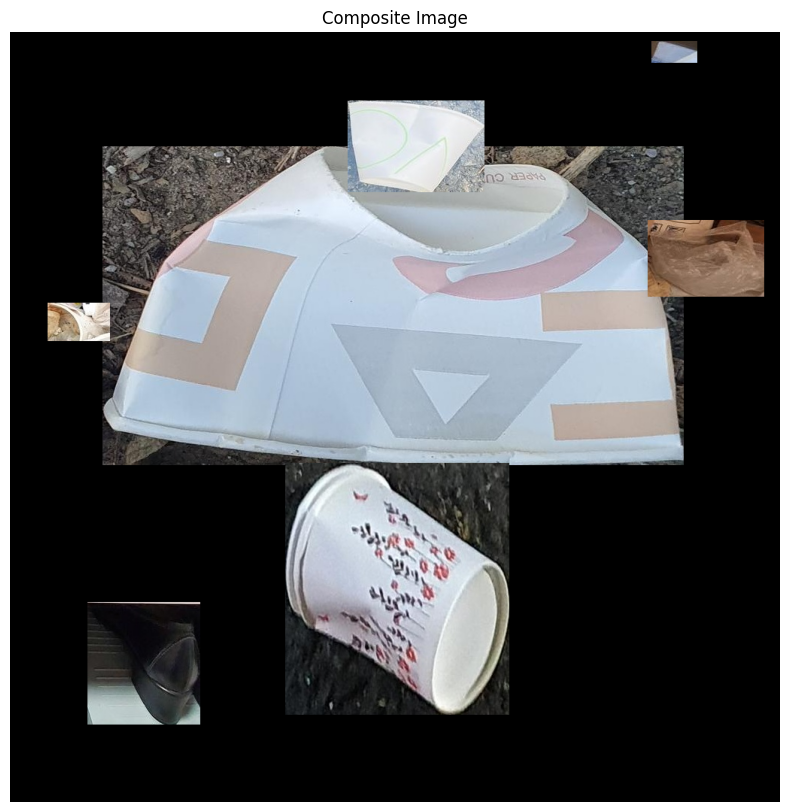

{'boxes': [[123, 152, 896, 576], [449, 91, 631, 213], [366, 573, 664, 908], [50, 360, 133, 411], [853, 12, 914, 41], [848, 250, 1003, 352], [103, 758, 253, 921]], 'labels': [3, 3, 3, 3, 7, 8, 10]}


In [6]:
import matplotlib.pyplot as plt

# 사용 예시
data_dir = './data'  # 클래스별 폴더가 있는 경로
composite_image, target = load_random_images_from_classes(data_dir)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(composite_image, cv2.COLOR_BGR2RGB))  # OpenCV는 BGR 형식으로 이미지를 읽기 때문에 RGB로 변환
plt.axis('off')  # 축 숨기기
plt.title("Composite Image")
plt.show()

print(target)

In [22]:
a = {'boxes': []}

In [25]:
a['boxes'].append([1, 2, 3, 4])

In [26]:
a

{'boxes': [[1, 2, 3, 4], [1, 2, 3, 4]]}